# Probabilistic Graphs and Influence Maximization Lab

In [92]:
%matplotlib inline

import networkx as nx
import matplotlib.pyplot as plt
import random as rnd
import numpy as np
import pandas as pd
import seaborn as sns
from collections import deque
rnd.seed()

## Graph Input

In [3]:
G = nx.read_edgelist("karate.txt")

/home/quan/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


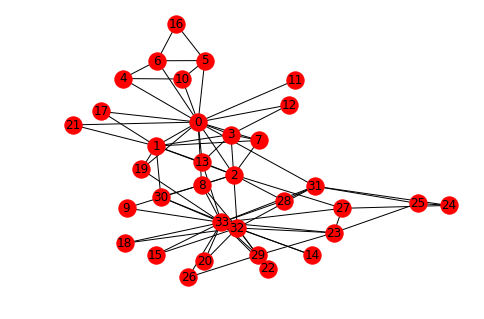

In [4]:
nx.draw(G, with_labels=True)
plt.show()

## Generating a Possible World

We set the probability of each edge:

In [5]:
p = 0.5

We define a method which takes a probabilistic graph, along with p and generates a possible world via sampling:

In [6]:
def gen_possible_world(G,p):
    F = nx.Graph()
    F.add_nodes_from(G) #every node in G belong to the possible world
    for e in G.edges():
        #for every edge in G, we sample the edge with probability p
        dice = rnd.random()
        if dice<=p: #we add th edge if the dice is successful
            F.add_edge(e[0],e[1])
    return F

In [7]:
G_p = gen_possible_world(G,p)

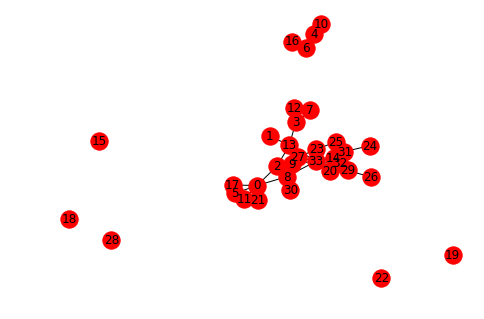

In [8]:
nx.draw(G_p, with_labels=True)
plt.show()

## Computing Reachability

We define a function which computes the reachability via sampling:

In [27]:
def reachability(G,s,t,p=0.1,rounds=1000):
    # G - the probabilistic graph
    # s - the source node
    # t - the target node
    # p - the value of the probability on each node
    # round - the number of sampling rounds
    good = 0
    for _ in range(rounds):
        G_p = gen_possible_world(G,p)
        if nx.has_path(G_p,s,t):
            good += 1
    return float(good)/float(rounds)

In [28]:
reachability(G,'5','1')

0.016

# 2.1 Test the reachability function with various p and rounds 

In [57]:
p_list = np.arange(0.1, 1.005, 0.005)
rounds_list = np.arange(1000, 30000, 200)

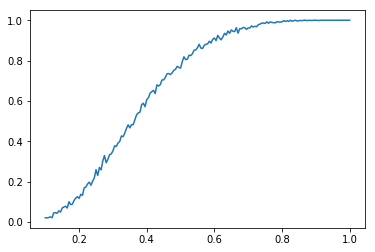

In [60]:
p_reachs = []
for p in p_list:
    reach = reachability(G,'5','1', p = p)
    p_reachs.append(reach)

sns.lineplot(x = p_list, y = p_reachs)

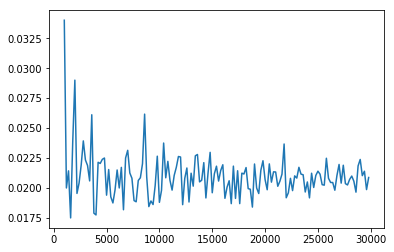

In [52]:
rounds_reachs = []
for rounds in rounds_list:
    reach = reachability(G,'5','1', rounds = rounds, p = 0.1)
    rounds_reachs.append(reach)
sns.lineplot(x = rounds_list, y= rounds_reachs)

# 2.2 Compute the expected spread for each node in the karate graph.

In [122]:
def expected_spreads(G, p = 0.1, num_tops = 5):
    nodes = G.nodes()
    spreads = []
    for node1 in nodes:
        reach = 0
        for node2 in nodes:
            if node1 != node2:
                reach += imporved_reachability(G, node1, node2, p = p)
        spreads.append((node1, reach))
    sorted_spreads = sorted(spreads, key = lambda x: x[1], reverse=True)
    top_spreads = sorted_spreads[:num_tops]
    top_nodes = list(map(lambda x: x[0], top_spreads))
    return top_nodes

In [89]:
top_five_nodes = expected_spreads(G)

In [90]:
top_five_nodes

['33', '0', '32', '2', '1']

In [123]:
def draw_top_reachabilities_nodes(G, p = 0.1):
    top_five_nodes = expected_spreads(G, p = p)
    color_map = []
    for node in G:
        if node in top_five_nodes:
            color_map.append('red')
        else: color_map.append('green')    
    nx.draw(G, with_labels=True, node_color = color_map)
    plt.show()

/home/quan/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


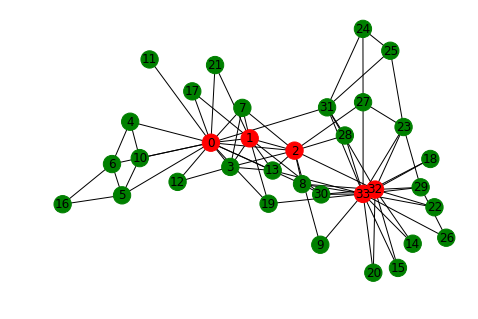

In [124]:
draw_top_reachabilities_nodes(G, p = 0.01)

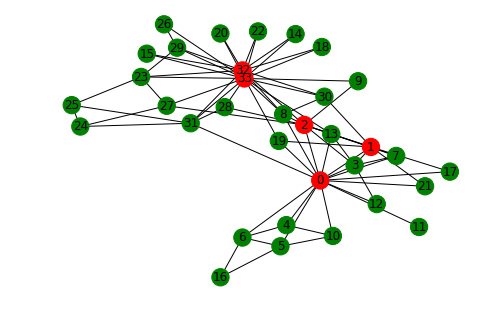

In [125]:
draw_top_reachabilities_nodes(G, p = 0.1)

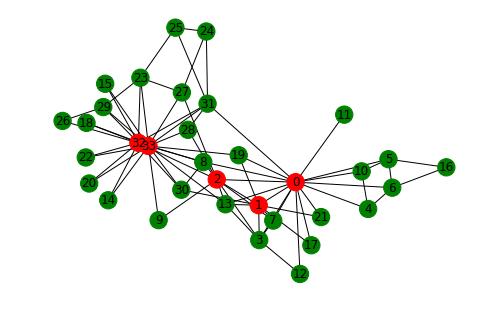

In [126]:
draw_top_reachabilities_nodes(G, p = 0.5)

# 2.3 Rewrite the function reachability 

In [104]:
def can_reach(G, s, t, p):
    Q = deque([s])
    visited = set()
    while len(Q) != 0:
        u = Q.popleft()
        if u == t:
            return 1
        visited.add(u)
        N = G.neighbors(u)
        for v in N:
            if v not in visited:
                dice = rnd.random()
                if dice <= p:
                    Q.append(v)
    return 0 
                        
def imporved_reachability(G,s,t,p=0.1,rounds=1000):
    good = 0
    for i in range(rounds):
        good += can_reach(G, s, t, p)
    return good / rounds

In [112]:
reachability(G,'5','1', p = 0.1, rounds = 1000)

0.016

In [113]:
imporved_reachability(G,'5','1', p = 0.1, rounds = 1000)

0.016

In [115]:
%time reachability(G,'5','1', p = 0.1, rounds = 1000)

CPU times: user 60.5 ms, sys: 4 µs, total: 60.5 ms
Wall time: 59.3 ms


0.018

In [116]:
%time imporved_reachability(G,'5','1', p = 0.1, rounds = 1000)

CPU times: user 3.23 ms, sys: 0 ns, total: 3.23 ms
Wall time: 2.85 ms


0.021

# 3.1 Function Spread

In [155]:
def can_reach_from_seeds(G, seed_nodes, t, p):
    Q = deque(set(seed_nodes))
    visited = set()
    while len(Q) != 0:
        u = Q.popleft()
        
        if u == t:
            return 1
        visited.add(u)
        N = G.neighbors(u)
        for v in N:
            if v not in visited:
                dice = rnd.random()
                if dice <= p:
                    Q.append(v)
    return 0 

def reachability_seeds(G, seed_nodes, t, p = 0.1, rounds = 1000):
    good = 0
    for i in range(rounds):
        good += can_reach_from_seeds(G, seed_nodes, t, p)
    return good / rounds
    
def spread(G, seed_nodes, p = 0.1, rounds = 1000):
    
    spread = 0
    for target_node in G.nodes():
        if target_node not in seed_nodes:
            spread += reachability_seeds(G, seed_nodes, target_node, p = p, rounds = rounds )
    return spread

# 3.2 function greedyIM

In [161]:
def IM(G, p = 0.1, k = 3):
    S = []
    total_spread = 0
    while len(S) < k:
        print(len(S))
        max_spread = 0
        max_u = None
        for u in G.nodes():
            m_spread = spread(G, S + [u], p = p) - total_spread
            if m_spread > max_spread:
                max_spread = m_spread
                max_u = u
        S = S + [max_u]
        total_spread = total_spread + max_spread
    return S, total_spread
            
                     

In [162]:
S, total_spread = IM(G, p = 0.1, k = 3)

0
1
2


In [163]:
S

['33', '0', '32']

In [189]:
total_spread

5.301

# 3.3 Highlight the result on the original graph plot

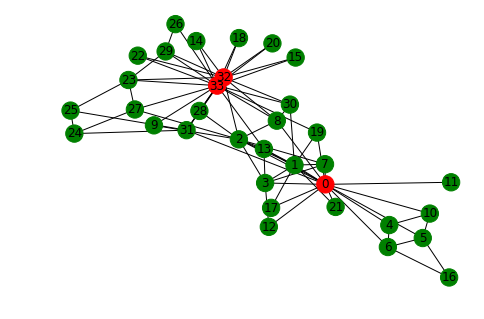

In [185]:
color_map = []
for node in G:
    if node in S:
        color_map.append('red')
    else: color_map.append('green')    
nx.draw(G, with_labels=True, node_color = color_map)
plt.show()

In [186]:
nodes = list(G.nodes())
rnd.shuffle(nodes)
random_selected_nodes = nodes[:3]

/home/quan/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


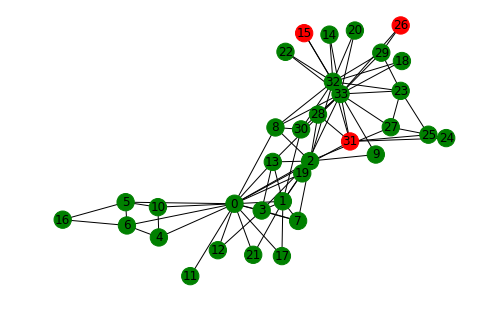

In [187]:
color_map = []
for node in G:
    if node in random_selected_nodes:
        color_map.append('red')
    else: color_map.append('green')    
nx.draw(G, with_labels=True, node_color = color_map)
plt.show()

In [188]:
spread(G, random_selected_nodes)

2.159